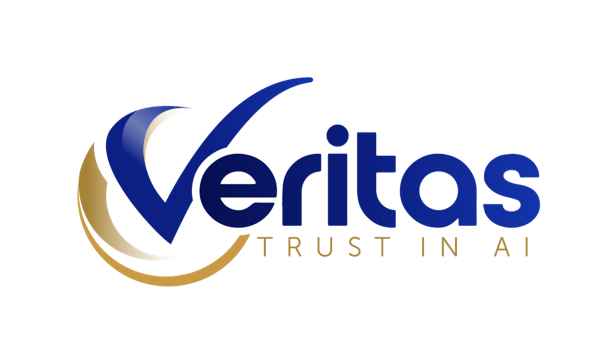

# Veritas Diagnosis Tool Demo : Credit Scoring Classification Model 
    
<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a credit scoring model and use daignosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness & transparency assessment report.
</p>    
<p>    
    Credit scoring model is a binary classification model for prediction customer loan repayment. <br/>
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Fairness & Transparency Diagnosis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 compute performance and fairness metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 compute trade off analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3 compute feature importance analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4 compute root cause analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.5 perform bias mitigation <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.6 compute transparency analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.7 save results in json artifact <br/>
</p>

# 1. Loading Credit Scoring Data and Model

## Importing Libraries 

In [1]:
#!pip install imblearn
# If facing SSL related errors, the below can be used instead.
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org imblearn

In [2]:
import numpy as np
import pandas as pd
import pickle
import sys

# making veritas available in search path
sys.path.append("../../")
# pip install imblearn
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
import os

%load_ext autoreload
%autoreload 2

## Loading Data 

Dataset used is generated from : [Kaggle hosted UCI credit card dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)

In [3]:
pth = "../../../../user_defined_files"

# Load Credit Scoring Test Data
file = os.path.join(pth, "veritas_data", "credit_score_dict.pickle")
input_file = open(file, "rb")
cs = pickle.load(input_file)

# Model Contariner Parameters
y_true = np.array(cs["y_test"])
y_pred = np.array(cs["y_pred"])
y_train = np.array(cs["y_train"])
p_grp = {"SEX": [1], "MARRIAGE": [1]}
up_grp = {"SEX": [2], "MARRIAGE": [2]}
x_train = cs["X_train"]
x_test = cs["X_test"]
model_name = "credit_scoring"
model_type = "classification"
y_prob = cs["y_prob"]

## Data Exploration

In [4]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0], x_train.shape[1]))
x_train.head()

No of rows: 22500 
No. of columns: 23


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,50000.0,1,2,2,28,0,0,0,0,0,...,25454.0,26030.0,26609.0,27662.0,1500.0,1500.0,1000.0,1000.0,1500.0,1100.0
1,210000.0,2,2,1,44,0,0,0,0,0,...,42889.0,42936.0,44936.0,47166.0,4534.0,3000.0,1000.0,2000.0,2230.0,1026.0
2,80000.0,2,1,1,29,-1,-1,-1,-1,0,...,1872.0,746.0,746.0,4424.0,358.0,1872.0,746.0,0.0,4424.0,0.0
3,30000.0,2,3,1,43,0,0,0,0,0,...,15459.0,15366.0,15680.0,15000.0,1481.0,1400.0,307.0,314.0,300.0,1770.0
4,200000.0,2,1,2,28,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,510.0


Class imbalance

In [5]:
counts = pd.Series(y_train).value_counts()
print("count of neg class: {} \ncount of pos class: {}".format(counts[0], counts[1]))

count of neg class: 4977 
count of pos class: 17523


Differently scaled columns

In [6]:
x_train.describe().astype(int)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,...,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500
mean,168028,1,1,1,35,0,0,0,0,0,...,47135,43407,40400,39077,5634,6009,5327,4831,4903,5267
std,130060,0,0,0,9,1,1,1,1,1,...,69917,64817,61373,60212,16336,24713,18575,16144,15541,17991
min,10000,1,0,0,21,-2,-2,-2,-2,-2,...,-157264,-170000,-53007,-339603,0,0,0,0,0,0
25%,50000,1,1,1,28,-1,-1,-1,-1,-1,...,2616,2295,1700,1235,988,800,390,291,237,115
50%,140000,2,2,2,34,0,0,0,0,0,...,20009,19060,17966,17046,2121,2005,1800,1500,1500,1500
75%,240000,2,2,2,41,0,0,0,0,0,...,60360,54526,50149,49112,5009,5000,4500,4000,4078,4007
max,1000000,2,6,3,75,8,7,8,8,8,...,1664089,891586,927171,961664,873552,1684259,896040,621000,426529,528666


## Building Model 
### (Optional. User can resume from section 2)

In [7]:
# Upsampling
categorical_features = [i for i, col in enumerate(x_train.columns) if str(x_train[col].dtype).startswith("int")]
smote = SMOTENC(random_state=0, categorical_features=categorical_features)
X_upsml, y_upsml = smote.fit_resample(x_train, y_train)

# Scaling
scaling = StandardScaler()
X_upsml_scld = scaling.fit_transform(X_upsml)

# Model fitting
log_reg = LogisticRegression(C=0.1, random_state=0, max_iter=4000)
log_reg.fit(X_upsml_scld, y_upsml)

LogisticRegression(C=0.1, max_iter=4000, random_state=0)

In [8]:
x_test_scaled = scaling.transform(x_test)
test_preds = log_reg.predict(x_test_scaled)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true, test_preds), 3)))

Balanced Accuracy: 0.667


In [9]:
# Using finetuned Threshold
best_th = 0.43

test_probs = log_reg.predict_proba(x_test_scaled)[:, 1]
test_preds = np.where(test_probs > best_th, 1, 0)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true, test_preds), 3)))

Balanced Accuracy: 0.685


# 2. Fairness & Transparency Diagnosis

## Import Veritas Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. CreditScoring is showcased in this notebook.

In [10]:
from aiverify_veritastool.model.modelwrapper import ModelWrapper
from aiverify_veritastool.model.model_container import ModelContainer
from aiverify_veritastool.usecases.credit_scoring import CreditScoring

## Create model object using Model Wrapper

In [11]:
class LRwrapper(ModelWrapper):
    def __init__(self, model_obj, classes=[0, 1]):
        self.model_obj = model_obj
        self.classes_ = classes

    def fit(self, X, y):
        # Upsampling
        categorical_features = [i for i, col in enumerate(X.columns) if X[col].dtype == "int8"]
        smote = SMOTENC(random_state=0, categorical_features=categorical_features)
        X, y = smote.fit_resample(X, y)

        # Scaling
        scaling = StandardScaler()
        X = scaling.fit_transform(X)

        self.model_obj.fit(X, y)

    def predict(self, x_test, best_th=0.43):
        test_probs = self.model_obj.predict_proba(x_test.values)[:, 1]

        # Using finetuned Threshold
        test_preds = np.where(test_probs > best_th, 1, 0)
        return test_preds

    def predict_proba(self, x_test):
        return self.model_obj.predict_proba(x_test.values)

In [12]:
log_reg_untrained = LogisticRegression(C=0.1)
model_obj = LRwrapper(log_reg_untrained)

In [13]:
model_obj.fit(x_train, y_train)

## Initializing Veritas Diganosis Library

In [14]:
# Create Model Container
container = ModelContainer(
    y_true,
    p_grp,
    model_type,
    model_name,
    y_pred,
    y_prob,
    y_train,
    x_train=x_train,
    x_test=x_test,
    model_object=model_obj,
    up_grp=up_grp,
)

<h5 align="center">Table 1: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |No|
| x_train     | data           | training      | train set features |-      |No|
| p_grp       | protected vars |    -          | list of privileged groups| { 'SEX': [ 1 ] , 'MARRIAGE': [ 1 ] }   |Yes|
| up_grp       | protected vars |    -          | list of unprivileged groups| { 'SEX': [ 2 ] , 'MARRIAGE': [ 2 ] }   |No|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'credit'    |Yes|
| model_name  | model          |    -          | name of model | 'credit scoring'   |No|


In [15]:
# Create Use Case Object
cre_sco_obj = CreditScoring(
    model_params=[container],
    fair_threshold=80,
    fair_concern="eligible",
    fair_priority="benefit",
    fair_impact="normal",
    perf_metric_name="accuracy",
    tran_row_num=[20, 40],
    tran_max_sample=1000,
    tran_pdp_feature=["LIMIT_BAL"],
    tran_max_display=10,
)

<h5 align="center">Table 2: Credit Scoring parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_threshold | fairness metric thresolding |threshold used for assessment|floating value between 0 and 1 (treated as actual <br/> value) or 1 and 100 (treated as p%)   |No|
| fair_concern |fair_metric selection| for auto-suggestion: most concerned cohort| "eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection| for auto-suggestion: top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection | for auto-suggestion: impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_metric_type  | fair_metric selection | for auto-suggestion: type of metric | "difference" or "ratio"  |No|
| fair_metric_name      | metric name |primary fairness metric | "auto" or any of supported ones <br/> like "expected_harm"   |No|
| perf_metric_name      | metric name |primary performance metric |"expected_profit"   |Yes|
| tran_row_num      | transparency parameter |row number for local interpretability plot starting with 1 |list of integers   |No|
| tran_max_sample      | transparency parameter |sampling size for transparency analysis |float value between 0 and 1 (treated as <br/> percentage of rows)  or  int treated as #rows   |No|
| tran_pdp_feature      | transparency parameter |feature list for pdp plots |list of features   |No|
| tran_pdp_target      | transparency parameter |class label for pdp plots(required for multi-class model) |string |No|
| tran_max_display      | transparency parameter |#features to be displayed in the transparency plots |int    |No|
| tran_processed_data      | transparency parameter |sample dataframe for the analysis incase x_train is a string |dataframe    |No|
| tran_processed_label      | transparency parameter |list of y_train(s) for the given tran_processed_data |list    |No|






## Starting Fairness diagnosis

In [16]:
cre_sco_obj.evaluate()

Evaluate performance:   0%|          

y_true_counts columns: Index(['proportion'], dtype='object')
y_true_counts:
            proportion
index                
pos_label      0.7788
neg_label      0.2212


/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(



Class Distribution
	pos_label                                                          77.880%
	neg_label                                                          22.120%


Performance Metrics
	Selection Rate                                             0.781 +/- 0.011
	Accuracy                                                   0.784 +/- 0.010
	Balanced Accuracy                                          0.685 +/- 0.013
	Recall                                                     0.863 +/- 0.011
	Precision                                                  0.860 +/- 0.008
	F1 Score                                                   0.861 +/- 0.007
	True Negative Rate                                         0.506 +/- 0.024
	False Negative Rate                                        0.137 +/- 0.011
	Negative Predictive Value                                  0.512 +/- 0.028
	ROC AUC Score                                              0.726 +/- 0.014
	Log-loss                                     

In [17]:
cre_sco_obj.evaluate(visualize=True, output=True)

In [18]:
cre_sco_obj.tradeoff()

Tradeoff:   0%|          


-------------------------------- 1. SEX --------------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.446
		Best balanced_acc*                                0.674
	 Separated Thresholds
		Privileged Threshold                              0.431
		Unprivileged Threshold                            0.422
		Best balanced_acc*                                0.688
	 Separated Thresholds under Neutral Fairness (0.001)
		Privileged Threshold                              0.413
		Unprivileged Threshold                            0.443
		Best balanced_acc*                                0.684
		*estimated by approximation, subject to the resolution of mesh grid

----------------------------- 2. MARRIAGE  -----------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.446
		Best balanced_acc*                                0.674
	 Separated

<h5 align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Table 3: Use of protected variable in model</h5>

|Fairness|Performace|Suggestion|
| -------- | ---------- | --------------- |
|Worse  |Worse	|Include|
|Better|Better|Exclude|
|Worse|Better|Examine Further|
|Better|Worse|Examine Further|

In [19]:
cre_sco_obj.feature_importance()

Feature importance:   0%|          




--------------------------------------------------1: Fairness on Marriage---------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |accuracy                 |equal_opportunity        |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|MARRIAGE                      |-0.013                   |0.070                    |fair to fair (+)    |Examine Further   |
----------------------------------------------------------------------------------------------------------------------------
|SEX                           |-0.013                   |0.070                    |fair to fair (+)    |Examine Further   |
-------------------------------------------------------------------------------------------------------------------------

Correlation analysis :   0%|          

PermutationExplainer explainer: 1003it [00:11,  9.34it/s]                          



Partial correlation matrix (Most correlated features for MARRIAGE, SEX):


,AGE,MARRIAGE,SEX,PAY_2,EDUCATION,LIMIT_BAL
AGE,1.000000,0.450315,0.122824,0.138133,0.226191,0.350984
MARRIAGE,0.450315,1.000000,0.043743,0.032798,0.159621,0.096548
SEX,0.122824,0.043743,1.000000,0.131123,0.022870,0.124805
PAY_2,0.138133,0.032798,0.131123,1.000000,0.168676,0.349224
EDUCATION,0.226191,0.159621,0.022870,0.168676,1.000000,0.216734
LIMIT_BAL,0.350984,0.096548,0.124805,0.349224,0.216734,1.000000


* No surrogate detected based on correlation analysis (threshold=0.7).


Root cause analysis:   0%|          



                              Top 10 contributors towards bias for class '1'      
                         Measured by SHAP-based Demographic Parity on 1002 samples




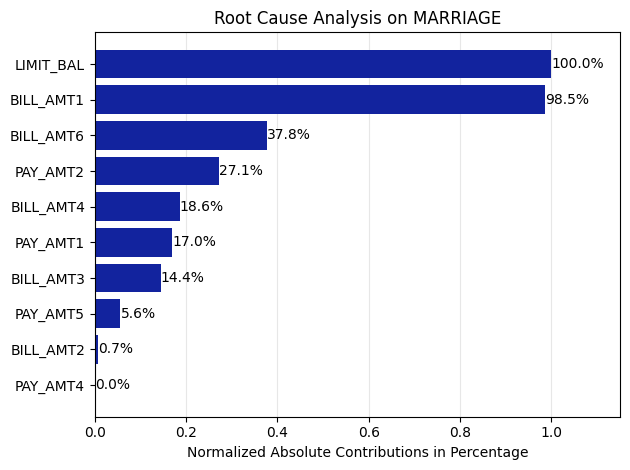

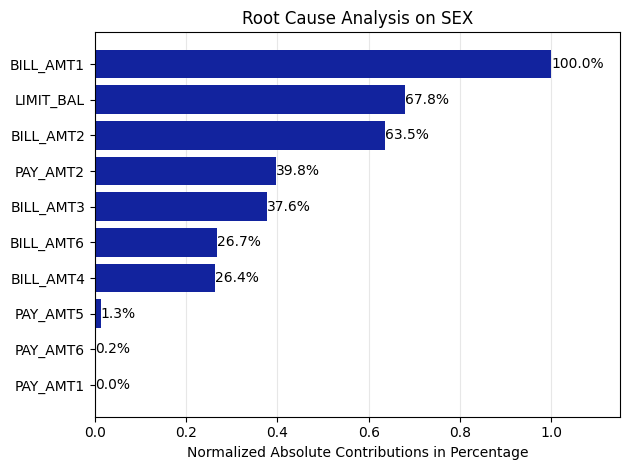

In [20]:
cre_sco_obj.rootcause(p_var=[])

In [21]:
mitigated = cre_sco_obj.mitigate(p_var=[], method=["reweigh", "correlate", "threshold"])

Bias mitigation :   0%|          


*Effective input for p_var = ['MARRIAGE', 'SEX']

                                Threshold tuning                                

--------------------------------------------------------------------------------
|Protected variable            |Privileged             |Unprivileged           |
--------------------------------------------------------------------------------
|MARRIAGE                      |0.414                  |0.449                  |
--------------------------------------------------------------------------------
|SEX                           |0.413                  |0.443                  |
--------------------------------------------------------------------------------


                                   Reweighing                                   

--------------------------------------------------------------------------------
|MARRIAGE, SEX                 |Label                  |Weight                 |
------------------------------------------------------

In [22]:
# y_pred can be used to reinitialise the model container and rerun fairness assessment
y_pred_sex_mitigated = mitigated["threshold"][0]
y_pred_marriage_mitigated = mitigated["threshold"][1]

In [23]:
# sample_weights can be used to reinitialise the model container and rerun fairness assessment
sample_weights_mitigated = mitigated["reweigh"][0]

In [24]:
# x_train, x_test can be used to reinitialise the model container and rerun fairness assessment
# Skipped in this demo as there are no surrogates detected
# x_train_mitigated = mitigated['correlate'][0]
# x_test_mitigated = mitigated['correlate'][1]

New dataset can be transformed with the calculated group weights as follows.

In [25]:
# for illustration, a new dataset is being sampled from x_test and y_true
indices = np.random.choice(x_test.index, size=50, replace=False)
x_test_sample = x_test.loc[indices].reset_index(drop=True)
y_true_sample = y_true[indices]
group_weights = mitigated["reweigh"][1]

In [26]:
transform_mitigated = cre_sco_obj.mitigate(
    method=["reweigh"], rw_weights=group_weights, transform_x=x_test_sample, transform_y=y_true_sample
)

Bias mitigation :   0%|          


*Effective input for p_var = ['MARRIAGE', 'SEX']

                                   Reweighing                                   

Calculating sample_weights for transform_x based on provided rw_weights,
transform_y.



In [27]:
# sample weights for new dataset
transform_mitigated["reweigh"]

array([1.04583249, 1.00371461, 1.04583249, 0.97419092, 0.99894996,
       0.97419092, 1.04583249, 0.99894996, 0.99894996, 1.0029314 ,
       0.99894996, 1.0029314 , 1.04583249, 0.97419092, 1.0029314 ,
       0.97419092, 0.98981414, 1.04583249, 0.86632958, 1.04583249,
       1.10287129, 0.99894996, 1.00371461, 0.99894996, 0.98981414,
       0.98981414, 1.04583249, 0.97419092, 0.99894996, 0.97419092,
       0.97419092, 0.99894996, 0.97419092, 1.04583249, 1.0029314 ,
       0.97419092, 0.99894996, 1.04583249, 0.97419092, 0.99894996,
       1.0029314 , 0.97419092, 1.0029314 , 1.10287129, 0.86632958,
       1.04583249, 1.04583249, 0.97419092, 0.97419092, 0.97419092])

## Starting Transparency Diagnosis

Running transparency for model 1        done      
     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


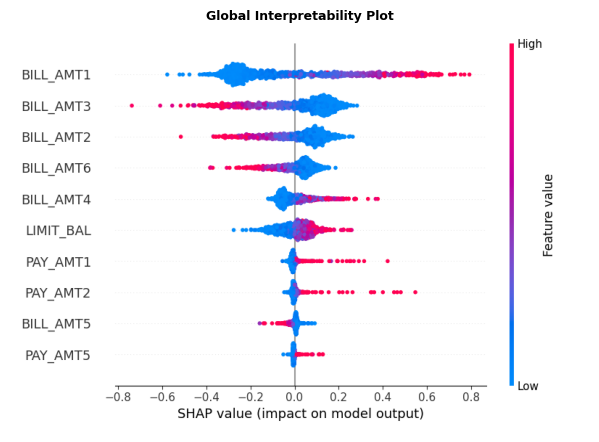

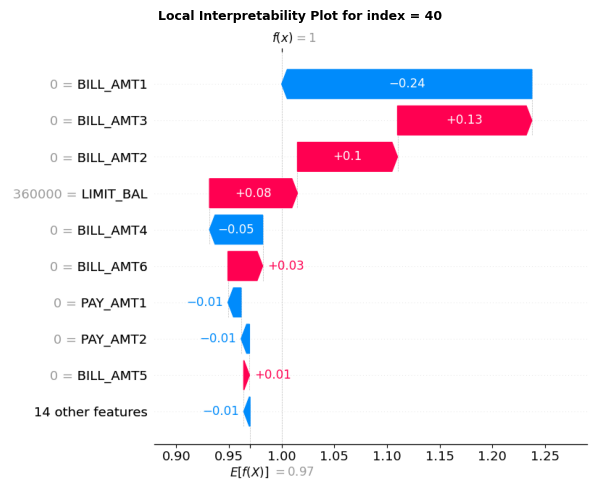

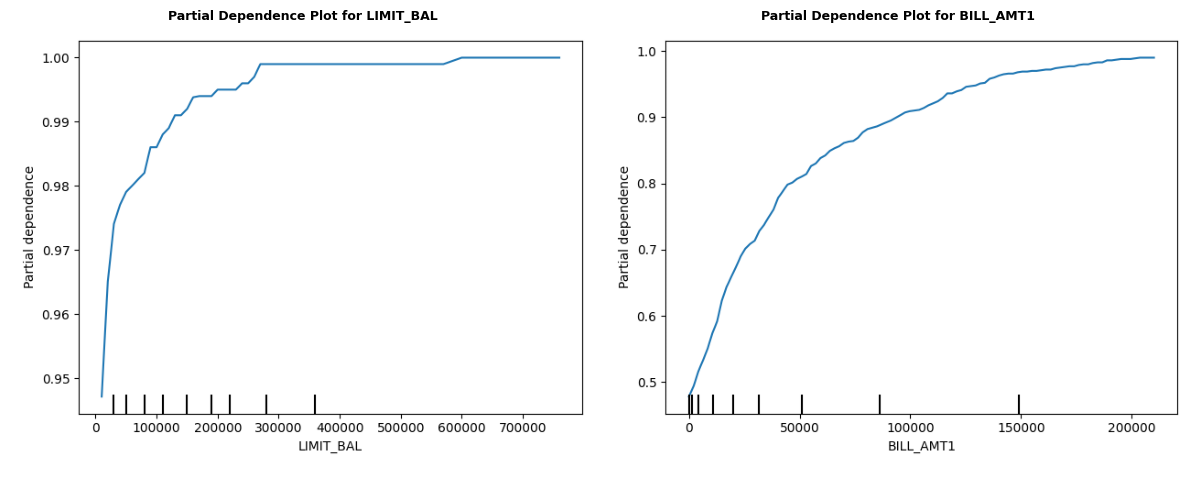

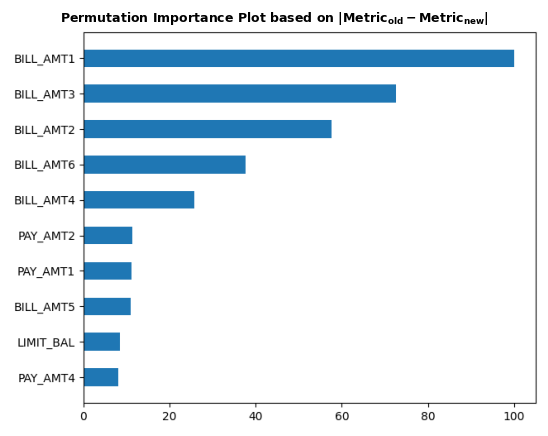

In [28]:
# run the entire transparency analysis
cre_sco_obj.explain()

<h5 align="center">Table 3: Transparency parameters   </h5>

| Var Name    | Description   |  Value        |Default|Compulsory|
| :---        |          ---: |          ---: |---:|---:|
| disable | disable any of the transparency analysis |list of valid inputs ['interpret','partial_dep','perm_imp']  |blank list |No|
| local_row_num |row number for local interpretability plot |integer   |last value of tran_row_num |No|
| model_num   |model for which assessment is required |1 or 2   |last model in model container |No|
| output      |boolean value for displaying the plots |True or False   |True |No|





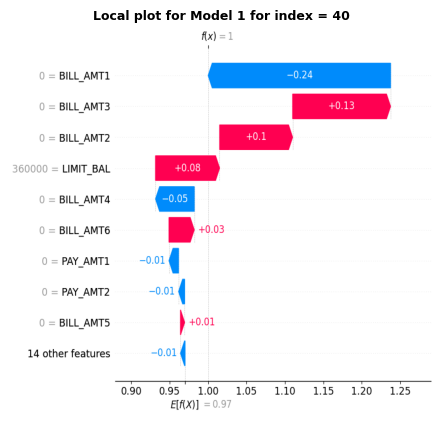

In [29]:
# get the local interpretability plot for specific row index and model
cre_sco_obj.explain(local_row_num=40, model_num=1)

## Compiling Results

In [30]:
# Previous Veritas way to compile results
# cre_sco_obj.compile()

# We can now assign the output to a variable and convert it into an AI Verify testing output
from aiverify_veritastool.util.aiverify import convert_veritas_artifact_to_aiverify

output = cre_sco_obj.compile(save_artifact=False)
convert_veritas_artifact_to_aiverify(model_artifact=output, output_dir="output")

Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            done      
     performance dynamics               done      
     individual fairness                done      
Running tradeoff                        done      
Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               done      
Running transparency for model 1        done      
Generating model artifact               

/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/aiverify_veritastool/util/aiverify.py:327: UserWarning: ground_truth key is missing
  warnings.warn(f"{key} key is missing")
/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/aiverify_veritastool/util/aiverify.py:327: UserWarning: data_path key is missing
  warnings.warn(f"{key} key is missing")
/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/aiverify_veritastool/util/aiverify.py:327: UserWarning: ground_truth_path key is missing
  warnings.warn(f"{key} key is missing")
